In this notebook I will analyse the differnece in the direct and indirect PII evaluation metrics across unlearning methods, addiitonally I wll inspect the utility of the model post unlearning.

#### Setup training data for Retain Only model

For a fair comparison, I also need to compare all of my unlearning with a model that is only trained on the Retain data ( Retain + Test_Retain). So I need to aggregate the correct data.

In [1]:
import pandas as pd
import json

### Extract Aggregated Evaluatiuon Metrics for TLPerMU

In [2]:
########## read 10 runs

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/PIIAnalysis'
configs = ['k1_match_first']
run_nums = [1,2,3,4,5,6,7,8,9,10]
dir_path = f'KDistance_Experiment_llama3.1-8b_E1_B16_{configs[0]}_run{run_nums[0]}/eval_results/eval.csv'


def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_experiment_results(experiment_path, configs, run_nums):
    results = []
    for in_text in [True,False]:
        for run_num in run_nums:
            P = 1 if in_text else 1.2
            dir_path = f'llama3.1-8b_E8_B16_C0.1_P_{P}_intext{in_text}_run{run_num}/eval_results/eval.csv'
            #dir_path = f'KDistance_Experiment_llama2-7b_E8_B16_{config}_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                method_name = "TLPerMU" if in_text else "PerMU"
                df['config'] = method_name
                df['run_num'] = run_num
              
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
          
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, configs, run_nums)
permu = res_df.groupby('config').mean(numeric_only=True).drop(columns=['run_num']).reset_index()


### Extract Evaluation Metrics for Retain Model

In [3]:
import json
import pandas as pd

def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_retain_model(full_experiment_path):

    df = pd.read_csv(full_experiment_path)
    df['config'] = 'Retain Model'
    # Also remove PII columns as before
    valid_cols = [col for col in df.columns if not col.startswith('PII')]
    df = df[valid_cols]

    return df

experiment_path_retain_model = '/projects/0/hpmlprjs/LLM/danp/UGBench/save_model/PII/retain_and_test_retain_llama3.1-8b_B32_G4_E5_lr2e-5_ComprehensiveQA/eval_results_1/eval.csv'
res_df = load_retain_model(experiment_path_retain_model)
retain_df = pd.DataFrame([res_df.mean(numeric_only=True)])
retain_df['config'] = 'Retain Model'

### Extraction Evaluatuion Metrics for the Rest of the models

In [ ]:
experiment_path = "/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/MethodComparison"
#configs = ["PerMU","grad_ascent","ULD","WHP","grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd"]
configs = ["grad_ascent+kl","grad_ascent+gd","dpo","dpo+kl","dpo+gd","npo","npo+kl","npo+gd","ULD","WHP","grad_ascent"] # "ULD","WHP","grad_ascent",



def load_experiment2_results(experiment_path, configs):
    results = []
    for run in range(1, 6):
        for config in configs:
                dir_path = f'ModelComparison_{config}_E8_Run{run}/eval_results/eval.csv'
                try:
                    df = pd.read_csv(experiment_path + '/' + dir_path)
                    df['config'] = config
                    df['run_num'] = run
                    
                    # Also remove PII columns as before
                    valid_cols = [col for col in df.columns if not col.startswith('PII')]
                    df = df[valid_cols]
                    
                    results.append(df)
                except FileNotFoundError:
                    print(f"File not found: {dir_path[16:]}")
                    continue

    return pd.concat(results, ignore_index=True)

res_df = load_experiment2_results(experiment_path, configs)
res_df.drop(columns=['Method','Submitted By'],inplace=True)

File not found: grad_ascent+kl_E8_Run1/eval_results/eval.csv
File not found: dpo+gd_E8_Run1/eval_results/eval.csv
File not found: ULD_E8_Run1/eval_results/eval.csv
File not found: WHP_E8_Run1/eval_results/eval.csv
File not found: grad_ascent+kl_E8_Run2/eval_results/eval.csv
File not found: dpo_E8_Run2/eval_results/eval.csv
File not found: dpo+gd_E8_Run2/eval_results/eval.csv
File not found: ULD_E8_Run2/eval_results/eval.csv
File not found: WHP_E8_Run2/eval_results/eval.csv
File not found: grad_ascent_E8_Run2/eval_results/eval.csv
File not found: grad_ascent+kl_E8_Run3/eval_results/eval.csv
File not found: dpo_E8_Run3/eval_results/eval.csv
File not found: dpo+gd_E8_Run3/eval_results/eval.csv
File not found: ULD_E8_Run3/eval_results/eval.csv
File not found: WHP_E8_Run3/eval_results/eval.csv
File not found: grad_ascent_E8_Run3/eval_results/eval.csv
File not found: grad_ascent+kl_E8_Run4/eval_results/eval.csv
File not found: dpo_E8_Run4/eval_results/eval.csv
File not found: dpo+gd_E8_Run4/

In [5]:
models_df = res_df.groupby('config').mean(numeric_only=True).drop(columns=['run_num']).reset_index()


In [ ]:
full_df = pd.concat([permu,retain_df,models_df], ignore_index=True)

In [ ]:
full_df['config'].value_counts()

config
PerMU             1
TLPerMU           1
Retain Model      1
dpo               1
dpo+kl            1
grad_ascent       1
grad_ascent+gd    1
npo               1
npo+gd            1
npo+kl            1
Name: count, dtype: int64

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative version with horizontal bar plots for better label readability
def plot_retain_forget_scores_horizontal(df, retain_col, forget_col, cat_col="method", title_prefix="Exact", figsize=(14, 10), adaptive_range=True,retain_title=None,forget_title=None):
    """
    Plot retain and forget scores using horizontal bar plots for better label readability.
    """
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col, cat_col]].reset_index()
    
    # Sort data for retain scores (increasing order)
    retain_order = plot_df.sort_values(retain_col)[cat_col].tolist()
    
    # Sort data for forget scores (decreasing order)
    forget_order = plot_df.sort_values(forget_col, ascending=False)[cat_col].tolist()
    
    # Plot 1: Retain Scores (Blue) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=retain_col, ax=ax1, color='steelblue', order=retain_order)
    if retain_title is not None:
        ax1.set_title(retain_title, fontsize=14, pad=20)
    else:
        ax1.set_title(f'{title_prefix} Retain Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax1.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax1.set_xlabel(f'{title_prefix} Retain Score', fontsize=12)
    
    # Add score labels at the end of retain bars
    for i, category in enumerate(retain_order):
        value = plot_df[plot_df[cat_col] == category][retain_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax1.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 2: Forget Scores (Red) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=forget_col, ax=ax2, color='crimson', order=forget_order)
    if forget_title is not None:
        ax2.set_title(forget_title, fontsize=14, pad=20)
    else:
        ax2.set_title(f'{title_prefix} Forget Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax2.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax2.set_xlabel(f'{title_prefix} Forget Score', fontsize=12)
    
    # Add score labels at the end of forget bars
    for i, category in enumerate(forget_order):
        value = plot_df[plot_df[cat_col] == category][forget_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax2.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Adapt x-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.1
        x_min_retain = max(0, retain_min - retain_padding)
        ax1.set_xlim(x_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.1
        x_min_forget = max(0, forget_min - forget_padding)
        ax2.set_xlim(x_min_forget, forget_max + forget_padding)
    
    plt.tight_layout(pad=3.0)
    plt.show()

In [9]:
full_df.rename(columns={'config':'method'},inplace=True)

In [ ]:
full_df.columns

Index(['method', 'para_scores_forget_exact',
       'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'para_scores_retain_exact',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'exact_retain_score', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'exact_forget

In [ ]:
full_df.rename(columns={'extraction_scores_forget_exact': 'Naive Forget ESR',
               'targetted_extraction_scores_forget_exact': 'Targeted Forget ESR',
               'extraction_scores_retain_exact': 'Naive Test Retain ESR',
               'targetted_extraction_scores_retain_exact': 'Targeted Test Retain ESR'},inplace=True)



full_df.rename(columns={'exact_forget_score': 'Direct Forget ESR',
               'inverse_scores_forget_exact': 'Inverse Forget ESR',
               'exact_retain_score': 'Direct Test Retain ESR',
               'inverse_scores_retain_exact': 'Inverse Test Retain ESR',
               'para_scores_retain_exact': 'Paraphrase Test Retain ESR',
               'para_scores_forget_exact': 'Paraphrase Forget ESR',
               'one_hop_scores_forget_pii': 'One Hop Forget ESR',
                'one_hop_scores_retain_pii': 'One Hop Test Retain ESR',
               },inplace=True)

#### Direct QA


The Direct QA are the (least) that an unlearning model should forget, they are the data that unlearning process is specifically done with. So, if the model does not do well on this setting, then it is hopeless for the other ones.

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

In [ ]:
full_df = full_df[~full_df['method'].isin(['dpo','grad_ascent'])]

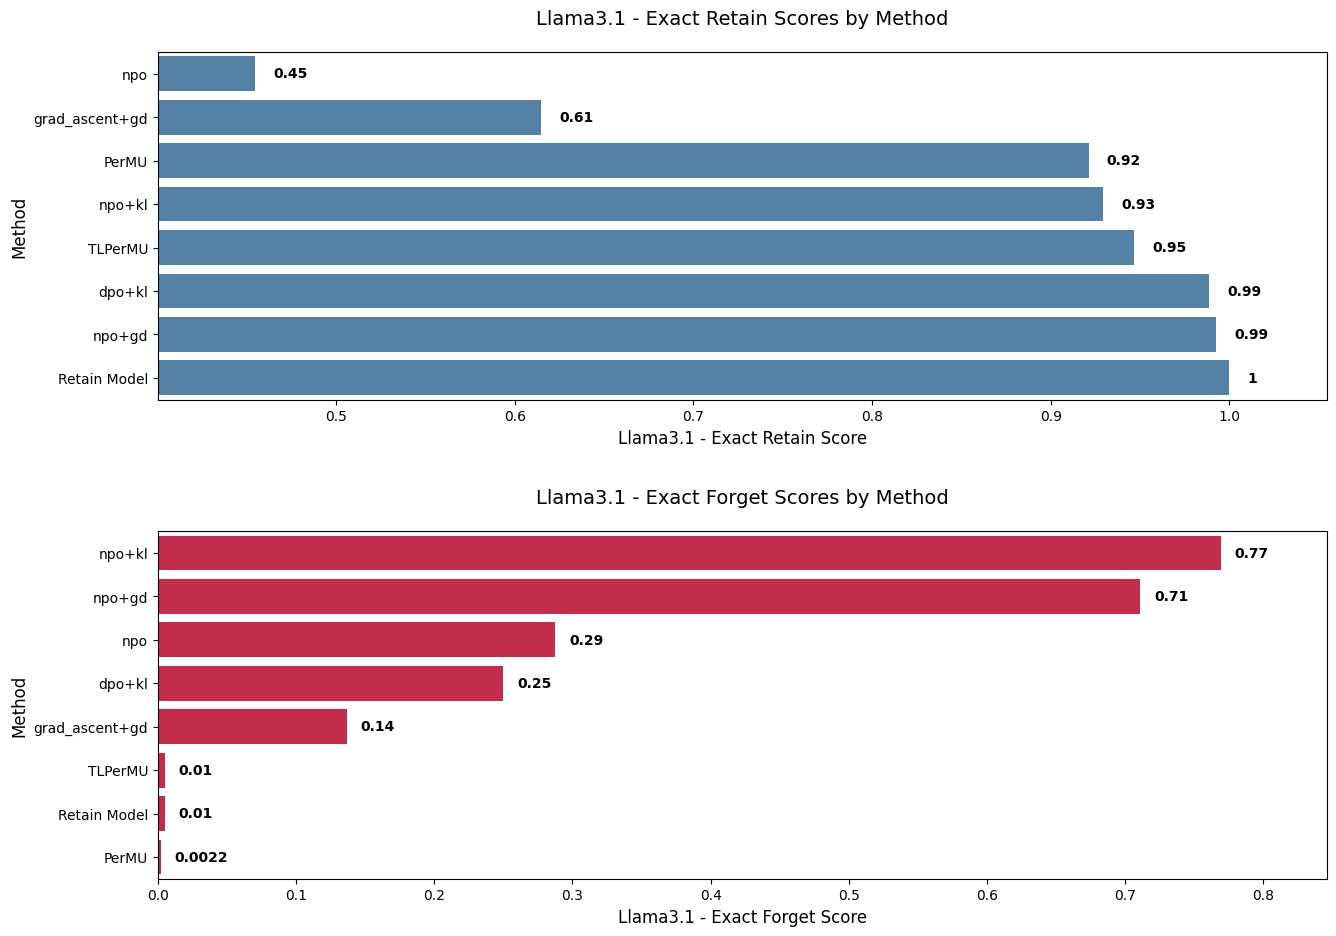

In [13]:
plot_retain_forget_scores_horizontal(full_df, 'Direct Test Retain ESR', 'Direct Forget ESR',title_prefix='Llama3.1 - Exact',)

In [ ]:
full_df[['method','Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR']]

,method,Direct Forget ESR,Paraphrase Forget ESR,One Hop Forget ESR,Inverse Forget ESR
0,PerMU,0.002167,0.006100,0.035849,0.123
1,TLPerMU,0.005000,0.012000,0.037736,0.045
2,Retain Model,0.005000,0.003000,0.018868,0.015
4,dpo+kl,0.250000,0.755000,0.603774,0.275
6,grad_ascent+gd,0.136667,0.189167,0.075472,0.105
7,npo,0.287500,0.363333,0.094340,0.145
8,npo+gd,0.710833,0.768333,0.566038,0.320
9,npo+kl,0.769167,0.788333,0.509434,0.315


In [27]:


full_df['Direct Forget ESR(%)'] = full_df['Direct Forget ESR'] * 100
full_df[['method','Direct Forget ESR(%)','ROUGE Forget','Prob. Forget','Truth Ratio Forget']] = full_df[['method','Direct Forget ESR(%)','ROUGE Forget','Prob. Forget','Truth Ratio Forget']].round(2)
full_df[['method','Direct Forget ESR(%)','ROUGE Forget','Prob. Forget','Truth Ratio Forget']]

,method,Direct Forget ESR(%),ROUGE Forget,Prob. Forget,Truth Ratio Forget
0,PerMU,0.22,0.36,0.20,0.58
1,TLPerMU,0.50,0.51,0.20,0.56
2,Retain Model,0.50,0.59,0.25,0.43
4,dpo+kl,25.00,0.19,0.60,0.20
6,grad_ascent+gd,13.67,0.34,0.00,0.12
7,npo,28.75,0.27,0.00,0.13
8,npo+gd,71.08,0.51,0.08,0.14
9,npo+kl,76.92,0.46,0.09,0.16


Right away,we can remove grad_ascent, grad_asccent+kl and dpo. They output giberrish for both retain and forget scores.

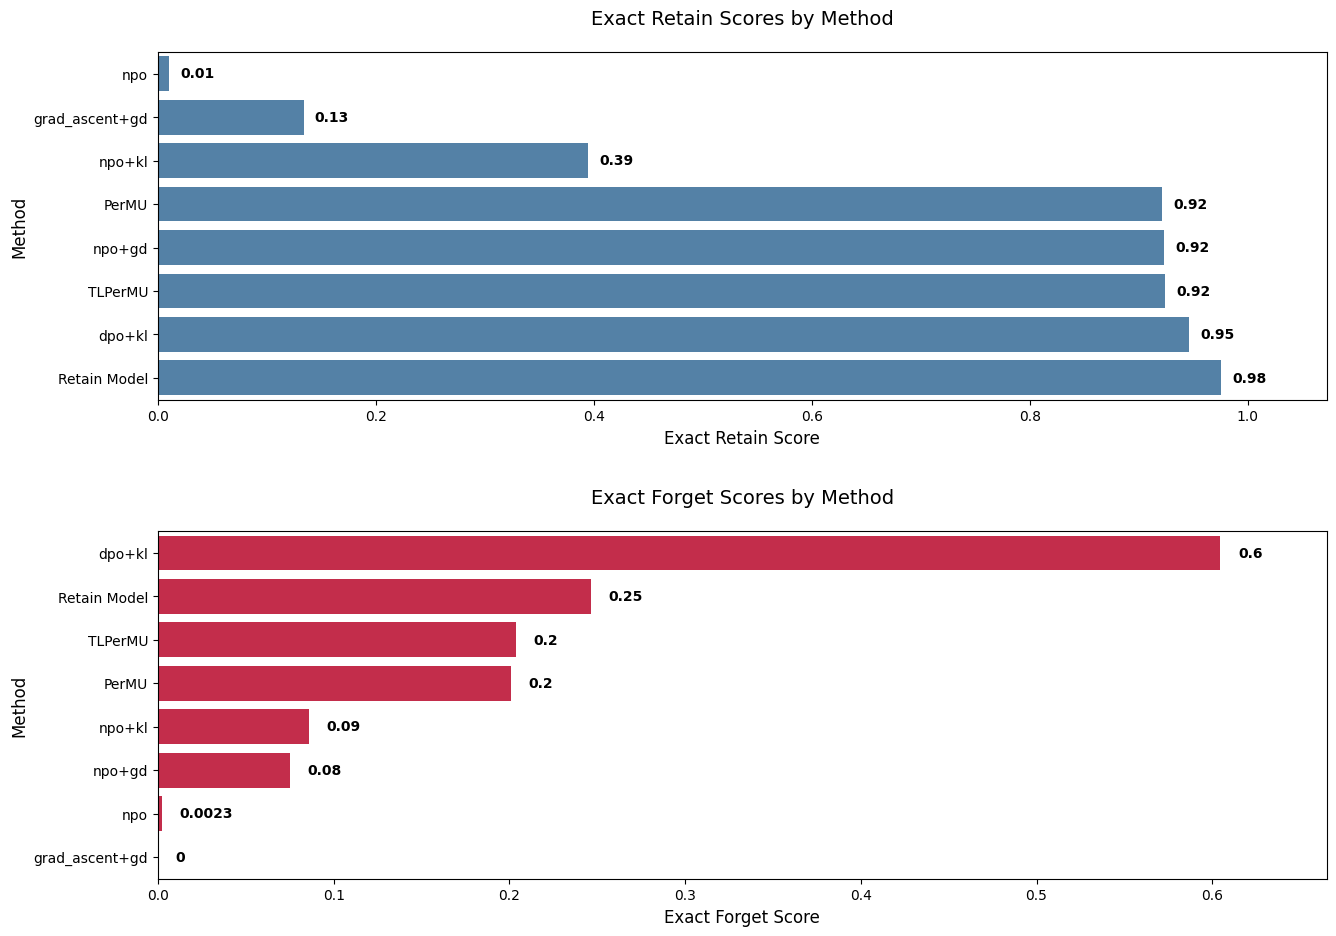

In [71]:
plot_retain_forget_scores_horizontal(full_df, 'Prob. Retain', 'Prob. Forget')

Right away, we can see that only the PerMU methods, gard_ascent and dpo are able to effectively forget the bulk of the information. It is important to note that that PerMU performs better at the forget metric than PerMUintext, but PermUintext has a slightly higher retain score.

#### Paraphrased Questiosn Eval Metrics


The paraphrsed QA is introduced by the UGBench papaer to recitify the very obvious mistake the other papers made, overfitting to the specific example.

**Total Samples (Normalizing Constant):**

- Forget ( 200 rows)
- Test_retain (250 rows)

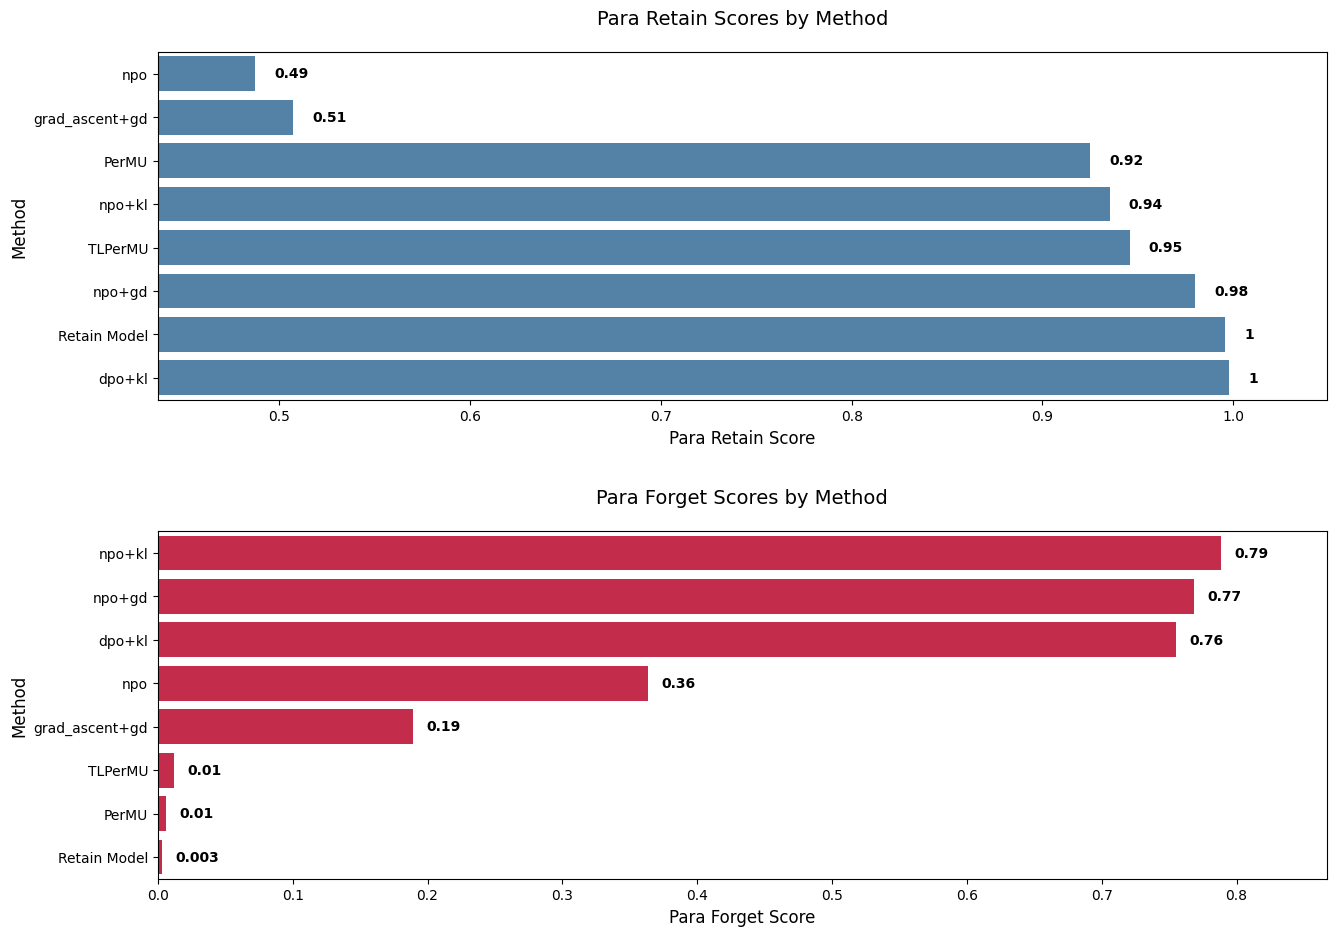

In [73]:
plot_retain_forget_scores_horizontal(full_df, 'Paraphrase Test Retain ESR', 'Paraphrase Forget ESR', title_prefix='Para')

We see mostly the same trend for the paraphrased methods, where PermU and PerMUintext are by far the best methods, with PerMU having a (slightly) better forget score, and PerMUintext having a (slightly) better retain score.

**NOTE**: Here we can see the downside of a method like ULD. For the DirectQA it had a pretty good Forget Score (0.18 leaked), while the paraphrased were able to leak much more PII (0.34). It is somewhat important to note though, that the ULD method has a substantially better retain score than PerMU

#### Extraction Attack

- Forget : 200
- Test_retain : 250

In [78]:
full_df[['method','Naive Forget','Naive Test Retain']]

,method,Naive Forget,Naive Test Retain
0,PerMU,0.000901,0.003904
1,TLPerMU,0.001001,0.006006
2,Retain Model,0.000000,0.005005
4,dpo+kl,0.002002,0.003003
6,grad_ascent+gd,0.000000,0.001001
7,npo,0.002002,0.000000
8,npo+gd,0.003003,0.004004
9,npo+kl,0.007007,0.002002


In [ ]:
plot_retain_forget_scores_horizontal(full_df, 'Naive Forget', 'Naive Test Retain', title_prefix='Naive Extraction')

#### Targetted Attack comparison

**Total Samples (Normalizing Constant):**

- Forget : 10
- Test_Retain: 30

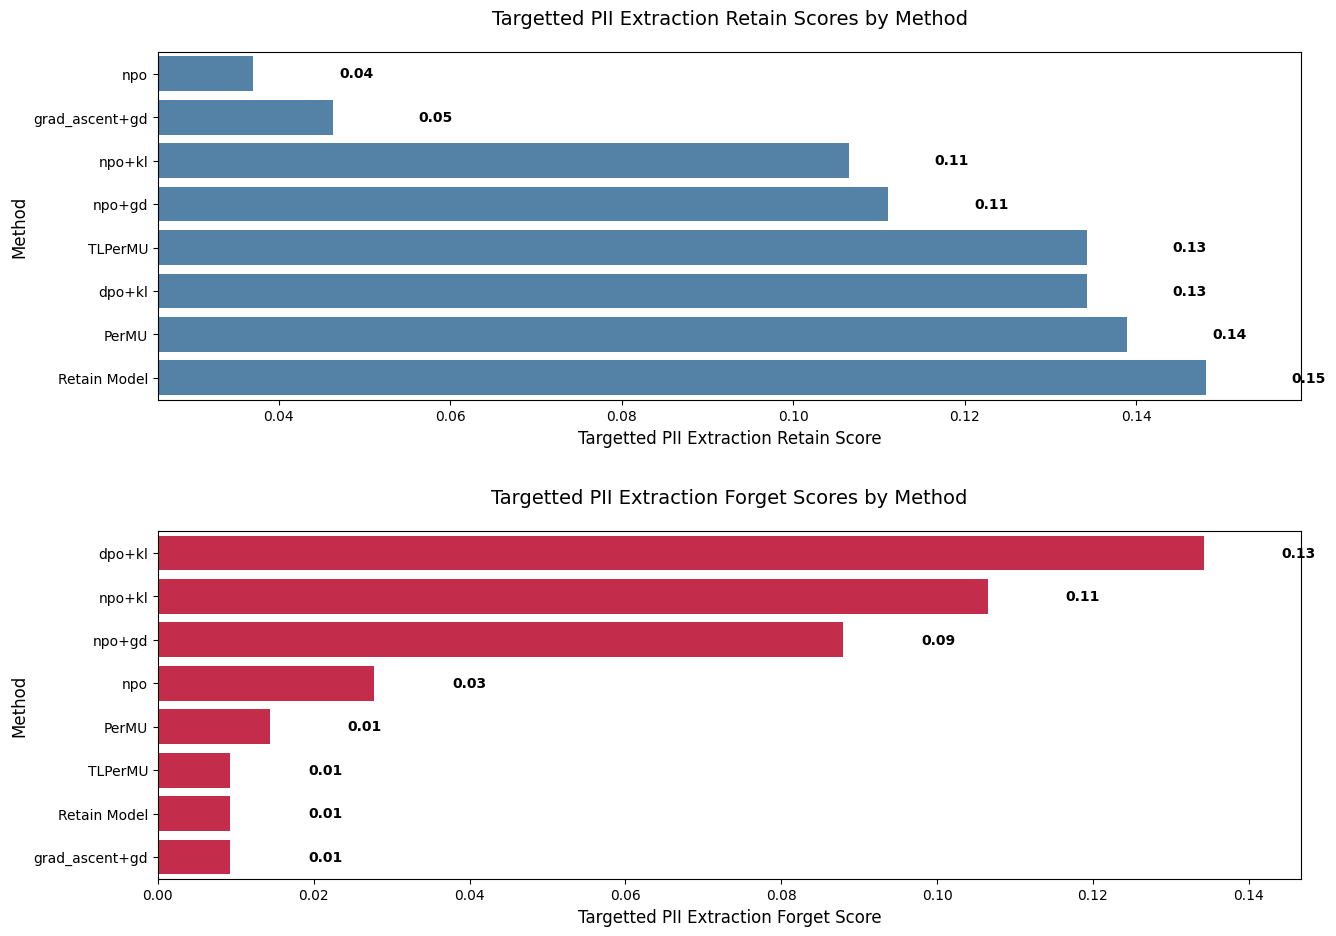

In [81]:
plot_retain_forget_scores_horizontal(full_df, 'Targeted Test Retain', 'Targeted Forget', title_prefix='Targetted PII Extraction')

In [83]:
full_df.loc[full_df['method']=='TLPerMU','method']  = 'PerMUtok'

Some observations :

1. We see that ULD and WHP have 0 extractions for both the retain set and forget set, this is because they generated the EOS token right away, I believe this is point against their generizability, especially keeping in mind that the retain set is suppoed to have some values.
2. Surprisingly, the PermUintext methods seems to leak less PII than the PerMU method. Important to note that I ran PerMUintext 10 times and this is the average of that, while PerMU ran only once (as per the paper)
3. The NPO+KL method has much higher lekage for the forget set, as do most of the other methods here, presumably this is due to the very low number of forget PII here (and possible the nature of the PII).


#### One-hop Results


**Total Samples (Normalizing Constant):**

- Forget : 53
- Test_retain : 69

In [87]:
full_df.columns

Index(['method', 'Paraphrase Forget ESR', 'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'Paraphrase Test Retain ESR',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'Direct Test Retain ESR', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'Direct Forget ES

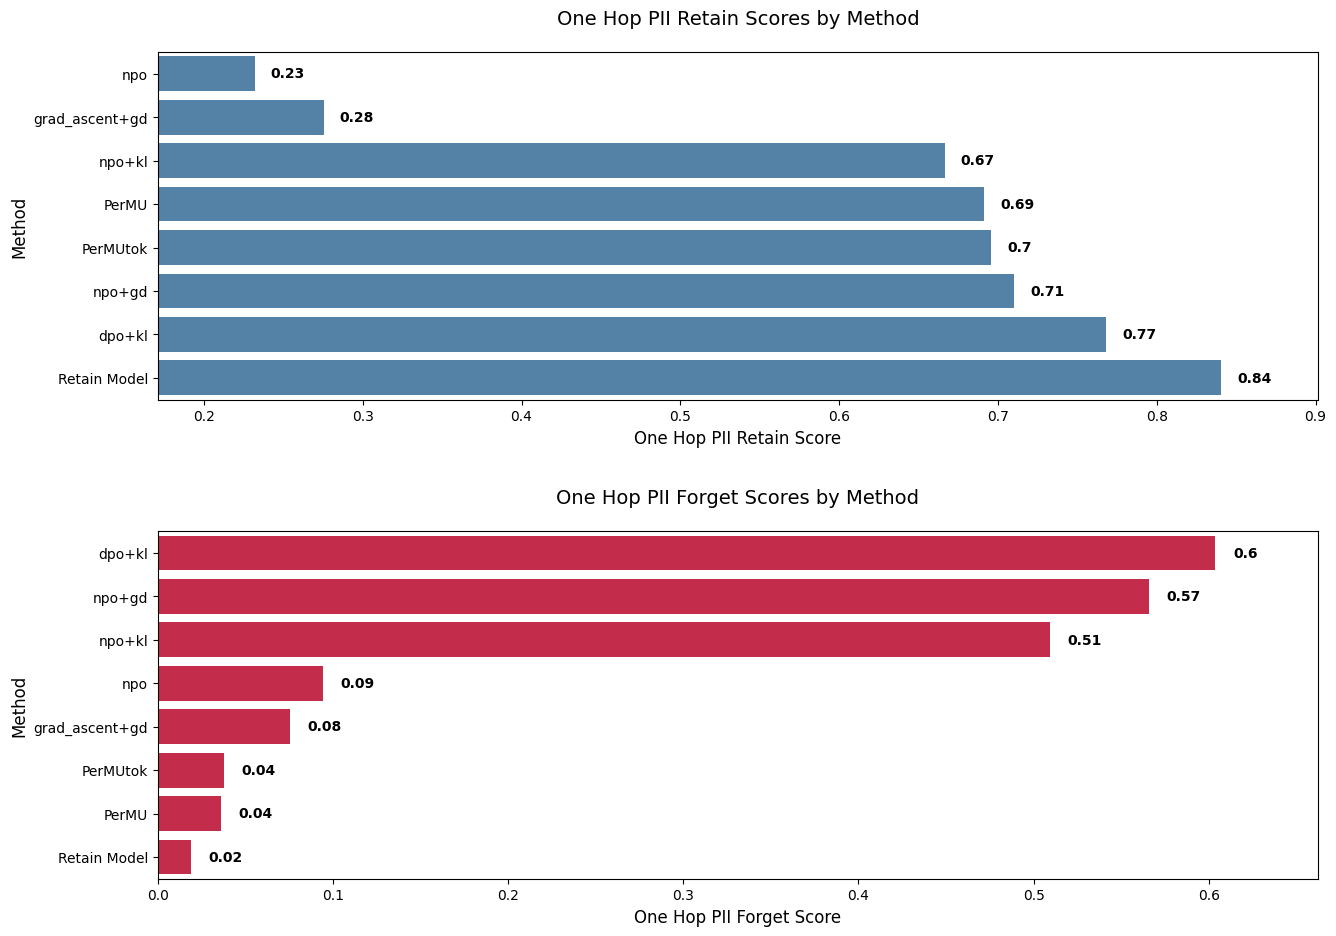

In [88]:
plot_retain_forget_scores_horizontal(full_df, 'One Hop Test Retain ESR', 'One Hop Forget ESR', title_prefix='One Hop PII')

1. Again ULD and WHP outputted nothing
2. Again, PerMU intext performs better than PerMU surprisingly. But this time, there are way more than 10 samples, so that is interesting to see.

#### Inverse Attack comparison

- Forget: 200
- Test_Retain : 250

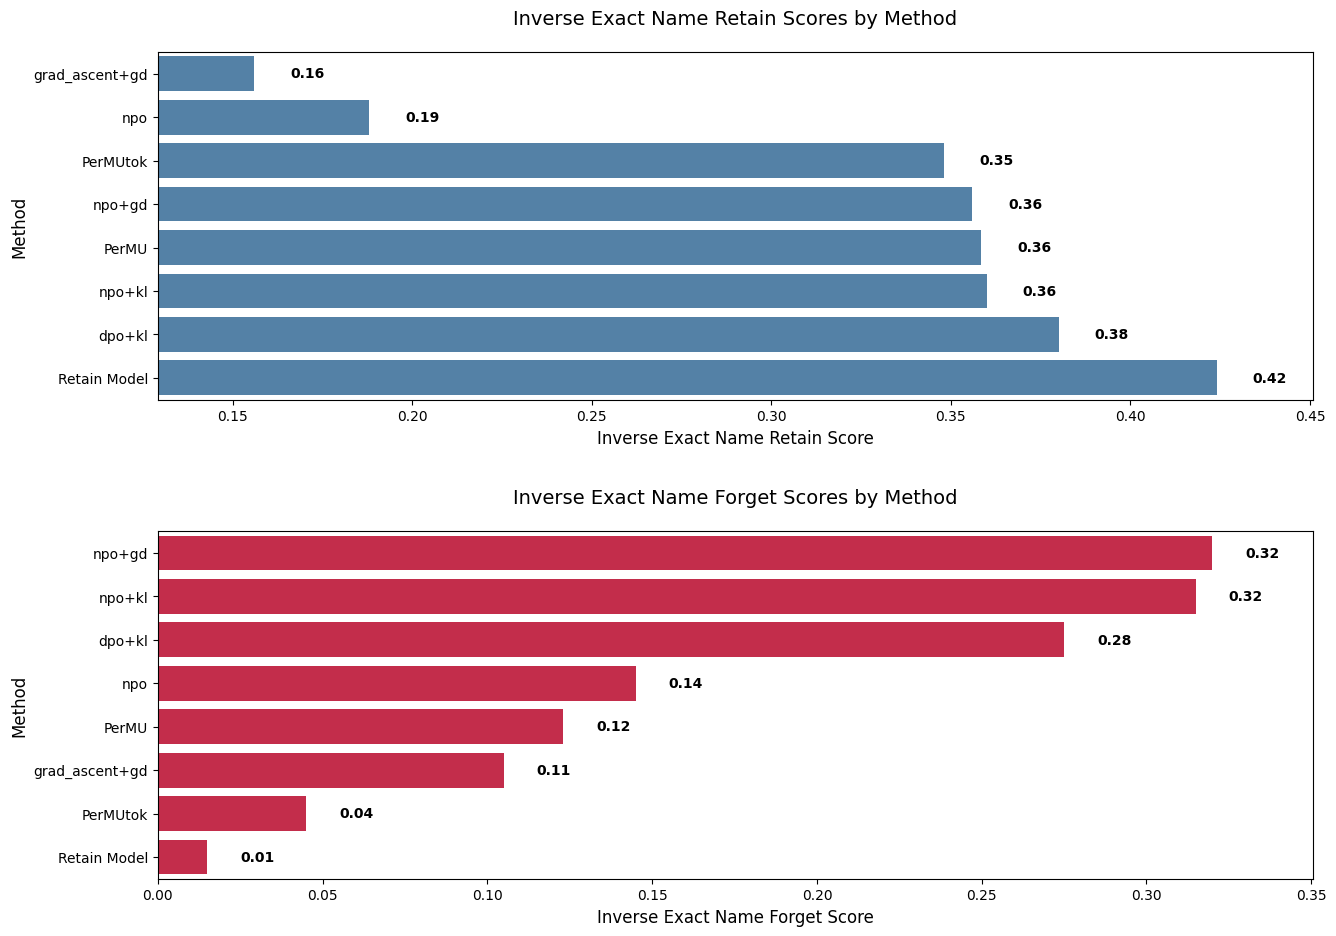

In [89]:
plot_retain_forget_scores_horizontal(full_df, 'Inverse Test Retain ESR', 'Inverse Forget ESR', title_prefix='Inverse Exact Name')

In [118]:
full_df.columns

Index(['method', 'Paraphrase Forget ESR', 'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'Paraphrase Test Retain ESR',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'Direct Test Retain ESR', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'Direct Forget ES

In [128]:
print_cols = ['method','Direct Forget ESR','Paraphrase Forget ESR','One Hop Forget ESR','Inverse Forget ESR','Direct Test Retain ESR','Paraphrase Test Retain ESR','One Hop Test Retain ESR','Inverse Test Retain ESR','Model Utility','Fluency Forget']

# Define the columns to multiply by 100
esr_cols = [
    'Direct Forget ESR',
    'Paraphrase Forget ESR', 
    'One Hop Forget ESR',
    'Inverse Forget ESR',
    'Direct Test Retain ESR',
    'Paraphrase Test Retain ESR',
    'One Hop Test Retain ESR',
    'Inverse Test Retain ESR'
]

# Create a copy of the dataframe for display
display_df = full_df[print_cols].copy()

# Multiply ESR columns by 100 (only the ones that exist in print_cols)
for col in esr_cols:
    if col in display_df.columns:
        display_df[col] = (display_df[col] * 100).round(2)

for col in ['Model Utility', 'Fluency Forget']:
    if col in display_df.columns:
        display_df[col] = (display_df[col]).round(2)


# Print the modified dataframe
display_df.sort_values(by='Direct Forget ESR', ascending=False, inplace=True)

In [134]:
full_df.columns

Index(['method', 'Paraphrase Forget ESR', 'para_scores_forget_partial_ratio',
       'para_scores_forget_token_set_ratio', 'Prob. Forget Paraphrase',
       'ROUGE Forget Paraphrase', 'Fluency Forget Paraphrase',
       'Truth Ratio Forget Paraphrase', 'Paraphrase Test Retain ESR',
       'para_scores_retain_partial_ratio',
       'para_scores_retain_token_set_ratio', 'Prob. Retain Paraphrase',
       'ROUGE Retain Paraphrase', 'Fluency Retain Paraphrase',
       'Truth Ratio Retain Paraphrase', 'Prob. Retain', 'ROUGE Retain',
       'Truth Ratio Retain', 'Prob. Real Authors', 'ROUGE Real Authors',
       'Truth Ratio Real Authors', 'Prob. Real World', 'ROUGE Real World',
       'Truth Ratio Real World', 'Prob. Forget', 'ROUGE Forget',
       'Truth Ratio Forget', 'Model Utility', 'Fluency Retain',
       'Fluency Real Authors', 'Fluency Real World', 'Fluency Forget',
       'Direct Test Retain ESR', 'partial_ratio_retain_score',
       'token_set_ratio_retain_score', 'Direct Forget ES

In [140]:
print_cols = ['method','Naive Forget','Naive Test Retain','Targeted Forget','Targeted Test Retain']

# Define the columns to multiply by 100
esr_cols = [
    'Naive Forget',
    'Naive Test Retain',
    'Targeted Forget',
    'Targeted Test Retain'
]

# Create a copy of the dataframe for display
display_df = full_df[print_cols].copy()

# Multiply ESR columns by 100 (only the ones that exist in print_cols)
for col in esr_cols:
    if col in display_df.columns:
        display_df[col] = (display_df[col] * 100).round(2)

# Print the modified dataframe
display_df.sort_values(by='Naive Forget', ascending=False, inplace=True)

In [ ]:
print_cols = ['method','Direct Forget ESR','Paraphrase Forget ESR','One Hop Forget ESR','Inverse Forget ESR','Direct Test Retain ESR','Paraphrase Test Retain ESR','One Hop Test Retain ESR','Inverse Test Retain ESR','Model Utility','Fluency Forget']

# Define the columns to multiply by 100
esr_cols = [
    'Direct Forget ESR',
    'Paraphrase Forget ESR', 
    'One Hop Forget ESR',
    'Inverse Forget ESR',
    'Direct Test Retain ESR',
    'Paraphrase Test Retain ESR',
    'One Hop Test Retain ESR',
    'Inverse Test Retain ESR'
]

# Create a copy of the dataframe for display
display_df = full_df[print_cols].copy()

# Multiply ESR columns by 100 (only the ones that exist in print_cols)
for col in esr_cols:
    if col in display_df.columns:
        display_df[col] = (display_df[col] * 100).round(2)

for col in ['Model Utility', 'Fluency Forget']:
    if col in display_df.columns:
        display_df[col] = (display_df[col]).round(2)

# Print the modified dataframe
display_df.sort_values(by='Direct Forget ESR', ascending=False, inplace=True)

Once again, it is very surprising to see that the PerMUintext method leaks less values than PerMU.

#### Averaging all of the metrics with Equal Weight

#### TOFU Metrics : Model Utility & Forget Fluency

In [15]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        #'Prob. Retain', 'ROUGE Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-10)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
full_df = calculate_model_utility(full_df)

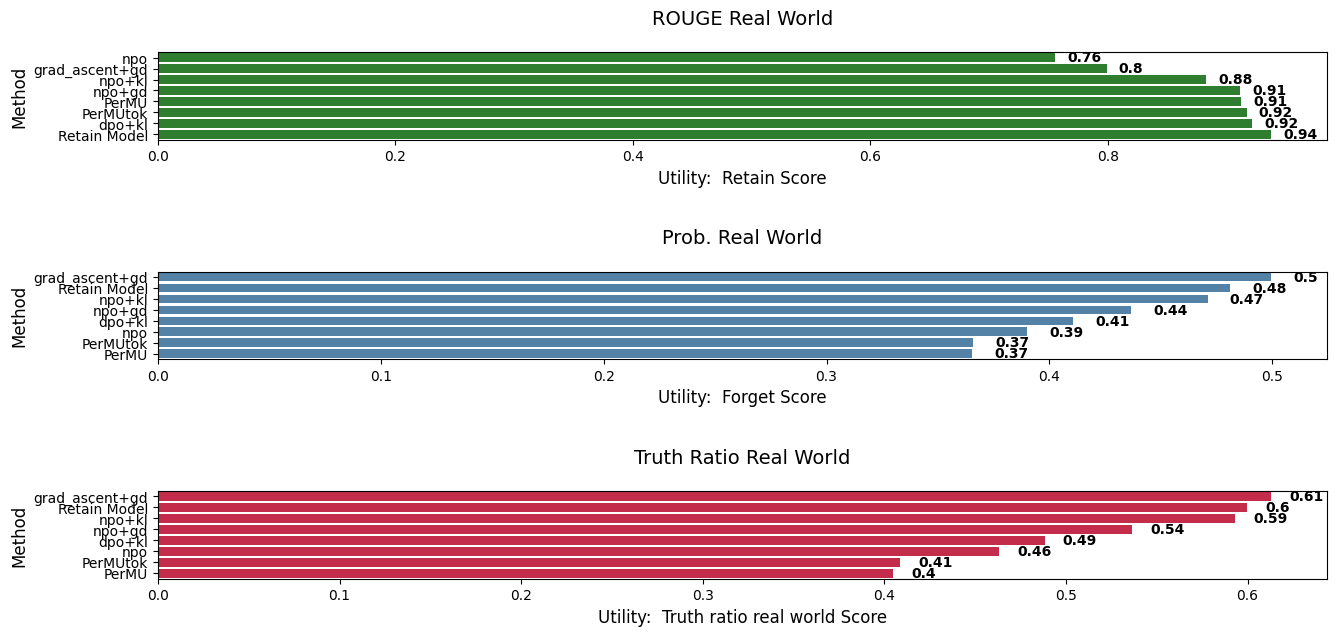

In [ ]:
# Plot 2: Real World metrics
plot_retain_forget_scores_horizontal(
    full_df, 
    'ROUGE Real World', 
    'Prob. Real World',
    'Truth Ratio Real World',
    retain_title='ROUGE Real World', 
    forget_title='Prob. Real World', 
    third_title='Truth Ratio Real World',
    title_prefix="Utility: ", 
    figsize=(14, 7), 
    adaptive_range=False
)

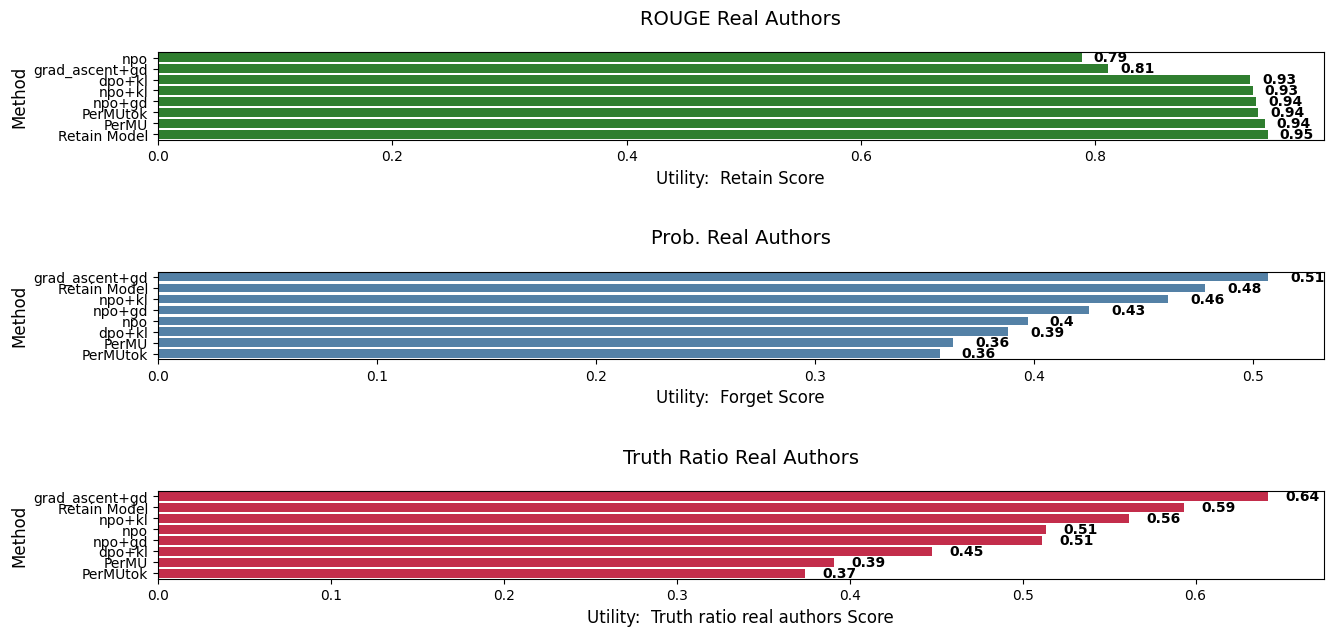

In [108]:
# Plot 2: Real World metrics
plot_retain_forget_scores_horizontal(
    full_df, 
    'ROUGE Real Authors', 
    'Prob. Real Authors',
    'Truth Ratio Real Authors',
    retain_title='ROUGE Real Authors', 
    forget_title='Prob. Real Authors', 
    third_title='Truth Ratio Real Authors',
    title_prefix="Utility: ", 
    figsize=(14, 7), 
    adaptive_range=False
)

In [21]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'ROUGE Retain', 'Prob. Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-6)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
full_df = calculate_model_utility(full_df)

In [22]:
utility_columns = [
        'ROUGE Retain', 'Prob. Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]

full_df[['config'] + utility_columns]

,config,ROUGE Retain,Prob. Retain,Truth Ratio Retain,ROUGE Real Authors,Prob. Real Authors,Truth Ratio Real Authors,Prob. Real World,ROUGE Real World,Truth Ratio Real World
0,PerMU,0.901749,0.921589,0.726573,0.944600,0.363328,0.391110,0.365262,0.912678,0.404820
1,TLPerMU,0.911986,0.924160,0.727781,0.939000,0.357083,0.374058,0.365812,0.917379,0.408535
2,Retain Model,0.945330,0.975972,0.869948,0.947333,0.478340,0.593284,0.481132,0.937607,0.599797
3,dpo,0.008114,0.089991,0.634723,0.005333,0.366078,0.398206,0.313856,0.000001,0.275962
4,dpo+kl,0.886964,0.946452,0.809022,0.932333,0.388354,0.447544,0.410428,0.921652,0.488198
5,grad_ascent,0.010297,0.000001,0.150436,0.006667,0.257244,0.328154,0.223356,0.000001,0.220782
6,grad_ascent+gd,0.703246,0.133927,0.902214,0.811000,0.507036,0.641908,0.499411,0.799145,0.612886
7,npo,0.320634,0.010516,0.889931,0.788667,0.397359,0.513516,0.389865,0.755698,0.463163
8,npo+gd,0.870062,0.923368,0.877672,0.937333,0.425383,0.511359,0.436809,0.911681,0.536307
9,npo+kl,0.529488,0.394799,0.854964,0.934333,0.461324,0.561681,0.470942,0.883191,0.592958


In [23]:
full_df[['config', 'Model Utility']]

,config,Model Utility
0,PerMU,0.554124
1,TLPerMU,0.550025
2,Retain Model,0.698983
3,dpo,0.000009
4,dpo+kl,0.605169
5,grad_ascent,0.000004
6,grad_ascent+gd,0.458118
7,npo,0.080995
8,npo+gd,0.643051
9,npo+kl,0.578717


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retain_forget_scores_horizontal(df, retain_col, forget_col, third_col, cat_col="method", title_prefix="Exact", figsize=(18, 15), adaptive_range=True, retain_title=None, forget_title=None, third_title=None):
    """
    Plot retain, forget, and third column scores using horizontal bar plots for better label readability.
    """
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col, third_col, cat_col]].reset_index()
    # Sort data for retain scores (increasing order)
    retain_order = plot_df.sort_values(retain_col)[cat_col].tolist()
    # Sort data for forget scores (decreasing order)
    forget_order = plot_df.sort_values(forget_col, ascending=False)[cat_col].tolist()
    # Sort data for third column scores (decreasing order - adjust as needed)
    third_order = plot_df.sort_values(third_col, ascending=False)[cat_col].tolist()
    # Plot 1: Retain Scores (Green) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=retain_col, ax=ax1, color='forestgreen', order=retain_order)
    if retain_title is not None:
        ax1.set_title(retain_title, fontsize=14, pad=20)
    else:
        ax1.set_title(f'{title_prefix} Retain Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax1.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax1.set_xlabel(f'{title_prefix} Retain Score', fontsize=12)
    
    # Add score labels at the end of retain bars
    for i, category in enumerate(retain_order):
        value = plot_df[plot_df[cat_col] == category][retain_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax1.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 2: Forget Scores (Blue) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=forget_col, ax=ax2, color='steelblue', order=forget_order)
    if forget_title is not None:
        ax2.set_title(forget_title, fontsize=14, pad=20)
    else:
        ax2.set_title(f'{title_prefix} Forget Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax2.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax2.set_xlabel(f'{title_prefix} Forget Score', fontsize=12)
    
    # Add score labels at the end of forget bars
    for i, category in enumerate(forget_order):
        value = plot_df[plot_df[cat_col] == category][forget_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax2.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 3: Third Column Scores (Red) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=third_col, ax=ax3, color='crimson', order=third_order)
    if third_title is not None:
        ax3.set_title(third_title, fontsize=14, pad=20)
    else:
        ax3.set_title(f'{title_prefix} {third_col.capitalize()} Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax3.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax3.set_xlabel(f'{title_prefix} {third_col.capitalize()} Score', fontsize=12)
    
    # Add score labels at the end of third column bars
    for i, category in enumerate(third_order):
        value = plot_df[plot_df[cat_col] == category][third_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax3.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Adapt x-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.1
        x_min_retain = max(0, retain_min - retain_padding)
        ax1.set_xlim(x_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.1
        x_min_forget = max(0, forget_min - forget_padding)
        ax2.set_xlim(x_min_forget, forget_max + forget_padding)
        
        # For third column scores
        third_min, third_max = plot_df[third_col].min(), plot_df[third_col].max()
        third_padding = (third_max - third_min) * 0.1
        x_min_third = max(0, third_min - third_padding)
        ax3.set_xlim(x_min_third, third_max + third_padding)
    
    plt.tight_layout(pad=3.0)
    plt.show()

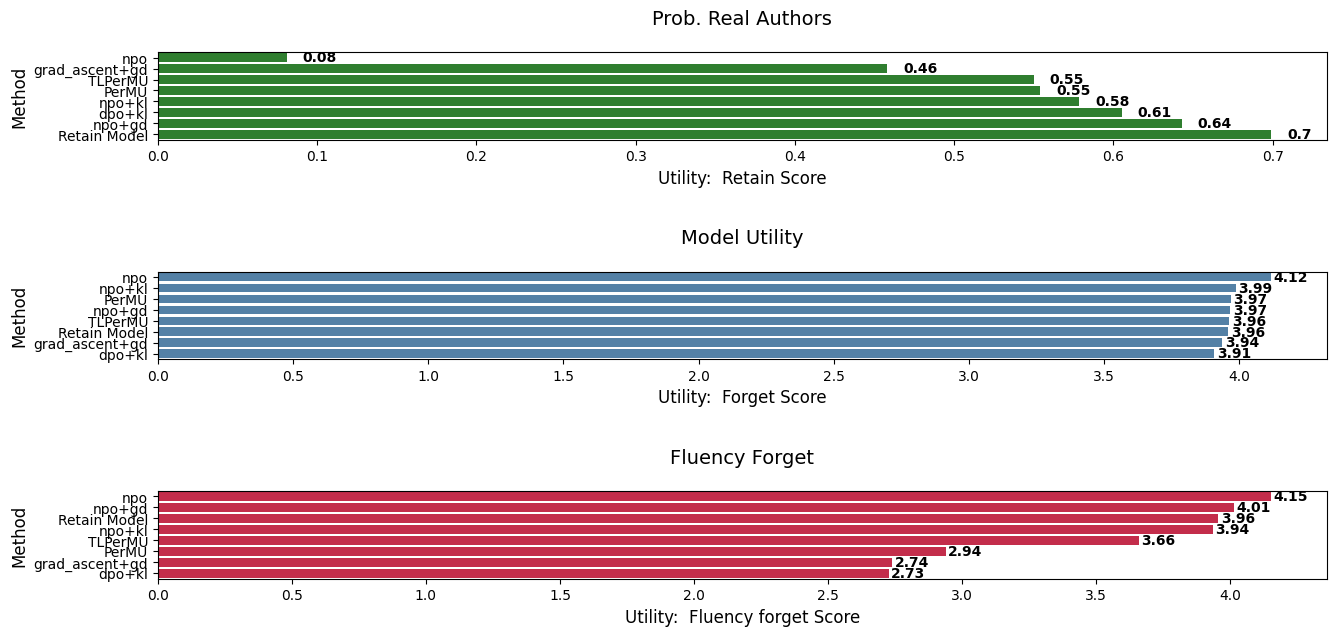

In [23]:
plot_retain_forget_scores_horizontal(full_df, 'Model Utility', 'Fluency Retain','Fluency Forget',retain_title='Prob. Real Authors', forget_title='Model Utility',third_title='Fluency Forget',title_prefix="Utility: ", figsize=(14, 7), adaptive_range=False)

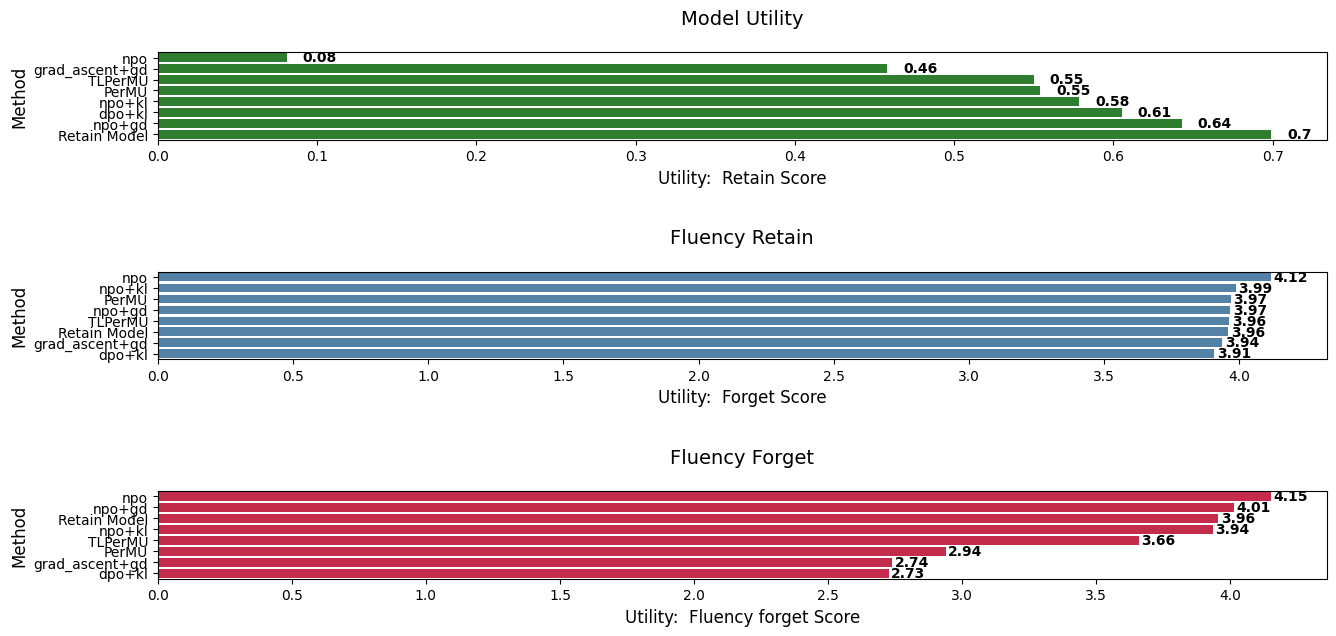

In [24]:
plot_retain_forget_scores_horizontal(full_df, 'Model Utility', 'Fluency Retain','Fluency Forget',retain_title='Model Utility', forget_title='Fluency Retain',third_title='Fluency Forget',title_prefix="Utility: ", figsize=(14, 7), adaptive_range=False)

1. Utility is overall comparable, at least when copmaring the methods that matter (PerMUintext and PerMU).

2. Fluency is quite a bit worse for PerMU.


Fluency Definition:  Fluency is measured by the
weighted average of bi- and tri-gram entropies [51], defined
as −
P
k
f(k) log2 f(k), where f(·) represents the n-gram
frequency distribution. A higher Fluency score indicates
more informative and diverse text generation.